# Atividade 4
## Crie um modelo de classificação para detectar mensagens Spam

* **Nome:** Matheus Freitas Martins
* **Matrícula:** ES111281


## Instalando as dependências

In [1]:
!pip install -U ydata-profiling

In [2]:
!pip install wordcloud

In [3]:
# Comando para exibir gráficos e visualizações dentro do próprio notebook, ao invés de abri-los em uma janela externa.
%matplotlib inline

In [4]:
import pandas as pd
import numpy as np
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.utils import resample
from ydata_profiling import ProfileReport
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.model_selection import cross_val_score
import seaborn as sns


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Martins\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Martins\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# 1. Carregando os dados

In [5]:
data = pd.read_csv("spam-datasset.csv")

## 1.1 Entendendo os dados

In [6]:
data.isnull().sum()

Category    0
Message     0
dtype: int64

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  5572 non-null   object
 1   Message   5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [8]:
data.describe()

,Category,Message
count,5572,5572
unique,2,5157
top,ham,"Sorry, I'll call later"
freq,4825,30


Na coluna "Message", há 5.157 mensagens únicas, o que indica que algumas mensagens estão duplicadas, pois há um total de 5.572 mensagens.

A maioria das mensagens pertence à categoria "ham" (mensagens legítimas), enquanto a quantidade de mensagens classificadas como "spam" é consideravelmente menor. A informação de que a categoria "ham" aparece 4.825 vezes em um dataset com 5.572 mensagens indica que o conjunto de dados está desbalanceado. 

### 1.1.1 Gerando relatório detalhado

In [9]:
profile = ProfileReport(data, title="Spam Data Profiling Report", explorative=True)
profile.to_widgets()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

In [10]:
profile.to_file("spam_data_profiling_report.html")

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

### 1.1.2 Observando frequência de palavras

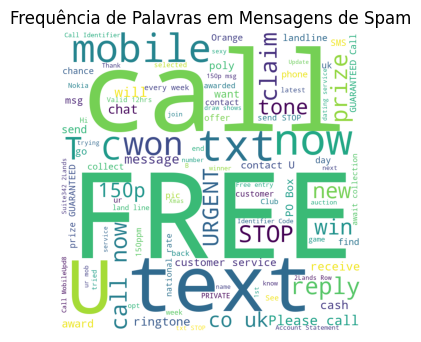

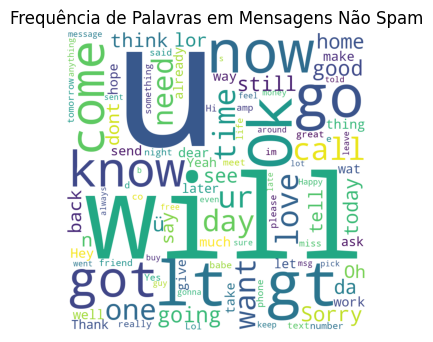

In [11]:
def visualize_word_frequencies(messages, title):
    text = ' '.join(messages)
    wordcloud = WordCloud(width=800, height=800, background_color='white', stopwords=None, max_words=100).generate(text)
    
    plt.figure(figsize=(3, 3), facecolor=None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.title(title)
    plt.show()

spam_messages = data[data['Category'] == 'spam']['Message']
ham_messages = data[data['Category'] == 'ham']['Message']

visualize_word_frequencies(spam_messages, 'Frequência de Palavras em Mensagens de Spam')
visualize_word_frequencies(ham_messages, 'Frequência de Palavras em Mensagens Não Spam')


## 1.2 Fazendo o pré-processamento

In [12]:
data = data.copy()
# Removendo as linhas duplicadas do conjunto de dados.
data = data.drop_duplicates()
# Mapeando as categorias (ham e spam) para valores numéricos (0 e 1).
data['Category'] = data['Category'].replace({'ham': 0, 'spam': 1})

# 2. Criando atributos relevantes a partir do texto da mensagem

In [13]:
# Aplicando o stemming para reduzir as palavras ao seu radical.
stemmer = SnowballStemmer("english")
# Removendo palavras irrelevantes (stopwords).
stop_words = set(stopwords.words("english"))

# Função que tokeniza a mensagem, aplica o stemming e remove as stopwords e palavras não alfabéticas. 
# Retorna a mensagem pré-processada como uma string.
def preprocess(message):
    words = nltk.word_tokenize(message)
    words = [stemmer.stem(word.lower()) for word in words if word.lower() not in stop_words and word.isalpha()]
    return ' '.join(words)

data['Message'] = data['Message'].apply(preprocess)

# Balanceamento de dados
spam = data[data['Category'] == 1]
ham = data[data['Category'] == 0]


# Aplicando a técnica de reamostragem (upsampling) no conjunto de spam para igualar a quantidade de exemplos de cada classe.
spam_upsampled = resample(spam, replace=True, n_samples=len(ham), random_state=42)

# Concatena os subconjuntos de ham e spam_upsampled para criar um conjunto de dados balanceado.
data_balanced = pd.concat([ham, spam_upsampled])

# Embaralhando aleatoriamente as linhas do DataFrame balanced_data e reinicializando o índice das linhas para garantir que os exemplos de treinamento e teste sejam selecionados aleatoriamente e que a ordem dos exemplos não afete o desempenho do modelo.
data_balanced = data_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

In [14]:
data_balanced.value_counts()

Category  Message                                                                                 
1         privat account statement show point call identifi code expir                                60
          u secret admir look make contact r reveal think ur                                          29
          urgent mobil number award prize guarante call land line claim valid                         29
          urgent tri contact today draw show prize guarante call land line claim valid                29
          tri contact repli offer video handset anytim network min unlimit text camcord repli call    28
                                                                                                      ..
0         know god creat gap finger one made come amp fill gap hold hand love                          1
          know girl alway safe selfish know got pa thank good night                                    1
          know friend alreadi told                           

In [23]:
print(data_balanced)

      Category                                            Message
0            0  cbe realli good nowaday lot shop showroom citi...
1            1  tri contact offer new video phone anytim netwo...
2            1  valu vodafon custom comput pick win prize coll...
3            1  complimentari star ibiza holiday cash need urg...
4            1  privat account statement show point call ident...
...        ...                                                ...
9027         1  new mobil must go txt nokia collect today txta...
9028         1  wo believ true incred txts repli g learn truli...
9029         1  free msg singl find partner area real peopl wa...
9030         0  hello babi get back mom set comput fill belli ...
9031         1  urgent urgent free flight europ give away call...

[9032 rows x 2 columns]


AttributeError: 'DataFrame' object has no attribute 'get_feature_names'

# 3. Dividindo os dados em conjuntos de treinamento e teste

In [16]:
# 70% dos dados para treinamento e 30% para teste.
X_train, X_test, y_train, y_test = train_test_split(data_balanced['Message'], data_balanced['Category'], test_size=0.3, random_state=42)

# 4. Treinando o modelo de classificação

In [34]:
# Criando um objeto Pipeline que combina três etapas para processamento e classificação de texto:

# Vetorização de contagem de palavras. Gera uma matriz esparsa onde cada linha representa uma mensagem e cada coluna representa um termo (ou token) único no conjunto de dados. 
# Transformação TF-IDF (Term Frequency-Inverse Document Frequency). Podenra a importância das palavras no conjunto de dados com base em suas frequências nas mensagens.
# Aplicação do classificador Multinomial Naive Bayes. Utiliza frequências das palavras e probabilidades de classes para categorizar as mensagens.

# O primeiro passo é converter o texto bruto em um vetor de contagens de termos.
# O segundo passo consiste em obter o vetor de contagens de termos, que irá ponderar a importância das palavras usando a métrica TF-IDF
# Por fim, depois de ter a matriz TF-IDF, pode-se aplicar o classificador Multinomial Naive Bayes para treinar e fazer previsões.

model = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB()),
])

model.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', MultinomialNB())])

In [35]:
# Acessando o CountVectorizer ajustado a partir do Pipeline
vectorizer = model.named_steps['vect']

# Transformando os dados usando o CountVectorizer ajustado
X = vectorizer.transform(messages)

# Imprimindo o vocabulário
print("Vocabulário:")
print(vectorizer.get_feature_names_out())
print("\n")

# Imprimindo a matriz de contagem de tokens como um array
print("Matriz de contagem de tokens:")
print(X.toarray())

Vocabulário:
['aah' 'aaooooright' 'aathi' ... 'zoom' 'zouk' 'zyada']


Matriz de contagem de tokens:
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [27]:
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

# Exemplo de mensagens
messages = [
    'cbe realli good nowaday lot shop showroom citi',
    'tri contact offer new video phone anytim network',
    'valu vodafon custom comput pick win prize collect'
]

# Criação do DataFrame
data = pd.DataFrame(messages, columns=['Message'])

# Criação e ajuste do CountVectorizer
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(data['Message'])

# Imprimindo o vocabulário
print("Vocabulário:")
print(vectorizer.get_feature_names_out())
print("\n")

# Imprimindo a matriz de contagem de tokens como um array
print("Matriz de contagem de tokens:")
print(X.toarray())

Vocabulário:
['anytim' 'cbe' 'citi' 'collect' 'comput' 'contact' 'custom' 'good' 'lot'
 'network' 'new' 'nowaday' 'offer' 'phone' 'pick' 'prize' 'realli' 'shop'
 'showroom' 'tri' 'valu' 'video' 'vodafon' 'win']


Matriz de contagem de tokens:
[[0 1 1 0 0 0 0 1 1 0 0 1 0 0 0 0 1 1 1 0 0 0 0 0]
 [1 0 0 0 0 1 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 0 0]
 [0 0 0 1 1 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 1 0 1 1]]


# 5. Avaliando o desempenho do modelo

              precision    recall  f1-score   support

           0       0.99      0.94      0.97      1406
           1       0.94      0.99      0.97      1304

    accuracy                           0.97      2710
   macro avg       0.97      0.97      0.97      2710
weighted avg       0.97      0.97      0.97      2710



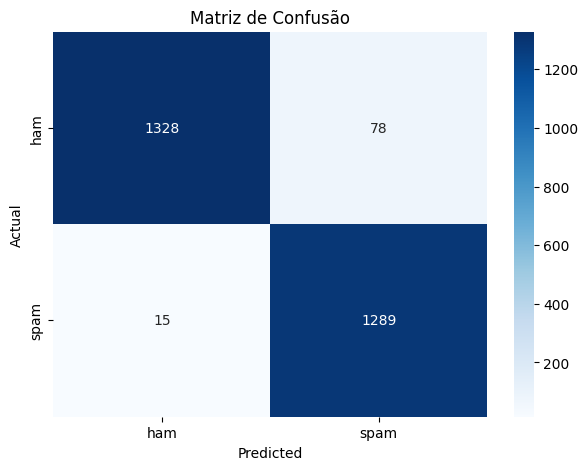

In [18]:
predictions = model.predict(X_test)
print(classification_report(y_test, predictions))

cm = confusion_matrix(y_test, predictions)
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['ham', 'spam'], yticklabels=['ham', 'spam'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Matriz de Confusão')
plt.show()

## Discussão dos resultados 

* **1328 (verdadeiros negativos):** O modelo previu corretamente "ham" (classe 0) 1.328 vezes.
* **78 (falsos positivos):** O modelo previu incorretamente "spam" (classe 1) quando a mensagem verdadeira era "ham" (classe 0) em 78 casos.
* **15 (falsos negativos):** O modelo previu incorretamente "ham" (classe 0) quando a mensagem verdadeira era "spam" (classe 1) em 15 casos.
* **1289 (verdadeiros positivos):** O modelo previu corretamente "spam" (classe 1) 1.289 vezes.

Com base nesta matriz de confusão, podemos tirar algumas conclusões sobre o desempenho do modelo:

* O modelo tem um bom desempenho na previsão de ambas as classes ("spam" e "ham"), já que a maioria das previsões são verdadeiros positivos e verdadeiros negativos.

* O modelo tem uma taxa relativamente baixa de falsos positivos (78) e falsos negativos (15), o que indica que o modelo é preciso em suas previsões.


Usando upsampling:

* F1-score (classe 0): 0.97
* F1-score (classe 1): 0.97

Usando downsampling:

* F1-score (classe 0): 0.91
* F1-score (classe 1): 0.92

Neste caso, o modelo utilizando upsampling apresenta um F1-score mais alto para ambas as classes (0.97). Portanto, com base nos resultados fornecidos, o modelo utilizando upsampling é a melhor opção para equilibrar a detecção correta de ambas as classes, pois um F1-score mais alto indica um melhor equilíbrio entre precisão e recall.



## Acurácia

In [19]:
print("Acurácia: ", accuracy_score(y_test, predictions))

Acurácia:  0.9656826568265683


# Analisando se ocorreu overfiting 

## cross-validation

In [20]:
# Calcule a acurácia usando validação cruzada com 5 folds
# folds =  divide os dados de treinamento em k-folds (subconjuntos) e treina o modelo em cada um desses subconjuntos, enquanto usa o restante dos dados como conjunto de validação.
# Divide o conjunto de treinamento em vários subconjuntos, treina e avalia o modelo várias vezes, usando um subconjunto diferente como conjunto de validação a cada vez.
scores = cross_val_score(model, X_train, y_train, cv=15, scoring='accuracy')

# Imprima os resultados
print(f"Acurácia média: {scores.mean():.2f}")
print(f"Desvio padrão: {scores.std():.2f}")

Acurácia média: 0.97
Desvio padrão: 0.01


De acordo com os resultados acima, é possível notar que o bom desempenho do modelo, pois conseguiu obter a acurácia média alta. Além disso, o desvio padrão baixo indica que os resultados são consistentes e que o modelo está generalizando bem para novos dados. 

## Desempenho no conjunto de treinamento e validação

In [21]:
# Faça previsões para os conjuntos de treinamento e teste
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Calcule a acurácia para os conjuntos de treinamento e teste
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Acurácia no conjunto de treinamento: {train_accuracy:.2f}")
print(f"Acurácia no conjunto de teste: {test_accuracy:.2f}")

Acurácia no conjunto de treinamento: 0.98
Acurácia no conjunto de teste: 0.97


Observando os resultados acima, nota-se que a diferença na acurácia do conjunto de treinamento para a acurácia do conjunto de teste é muito pequena, portanto indica que o modelo está generalizando bem para os dados não vistos.

# Teste

In [22]:
# Crie uma nova mensagem para teste
mensagens_de_teste = [
    "Congratulations, you won the prize.",
    "You have a meeting scheduled at 2 pm tomorrow.",
    "Email urgent", 
    "Can you confirm by tomorrow?",
]

# Faça a previsão usando o pipeline
previsao_de_categorias = model.predict(mensagens_de_teste)

# Verifique as categorias previstas
for i, previsao in enumerate(previsao_de_categorias):
    if previsao == 1:
        print(f"Mensagem {i + 1}: Esta mensagem é spam.")
    else:
        print(f"Mensagem {i + 1}: Esta mensagem é ham.")

Mensagem 1: Esta mensagem é spam.
Mensagem 2: Esta mensagem é ham.
Mensagem 3: Esta mensagem é spam.
Mensagem 4: Esta mensagem é ham.
